# Минипроект
## Автор: Кац Лев

<div style="text-align: right"> <em>В телескоп на Солнце можно посмотреть всего два раза в жизни.
Правым и левым глазом...</em> </div>

## Введение
В этом проекте мы попробуем исследовать активность Солнца. Обычно для этих целей исторически использовали значения площади пятен на солнце или числа Вольфа, которые также зависят от количества пятен и их площади. Пятно на солнце &mdash; некоторая область с меньшей температурой и потому темнее. Почему пятна? Вообще говоря расположение пятен определенным образом характеризует магнитное поле, что в свою очередь и связано с активностью.

<img width = '800px' src="images/sun.jpg">

## Наш датасет. Первичный анализ данных и предобработка.
Нам повезло, с 1874 года астрономы смотрели на солнце и получали нужные нам числа. Позже это собрали здесь https://solarscience.msfc.nasa.gov/greenwch.shtml.
В папке data расположен распокованный архив с файлами по годам.
Что в строке файла? Полное описание есть вот здесь https://solarscience.msfc.nasa.gov/greenwch/format.txt. Естественно, несколько разных групп занимались этими наблюдениями, поэтому у данных довольно разный формат местами и этот формат менялся в определенные годы. Также есть пропущенные значения. 
Отсюда мы извлечем дату, площадь пятна, расстояние от центра солнца, угол от направления на север.
Это соотвественно позиции 1-8, 41-44, 46-50, 52-56. Почему именно эти числа? Ну, все остальные значения представлены в сильно разных форматах и в определенные периоды могли не измеряться. Ну и менялась классификация.

### Получим некоторую таблицу из всех файлов

In [1]:
from os import listdir
from os.path import isfile, join
import re
import pandas as pd

In [2]:
def list_of_files(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f))]

In [3]:
time_pattern = re.compile(r"(.{4,4})(.{2,2})(.{2,2})")

In [4]:
def process_line(line):
    return {
        'time': pd.Timestamp(
            *map(int, re.search(time_pattern, line[:8:]).groups()), 12, 0
        ),
        'squere': float(line[40:44:]),
        'dist': float(line[45:50:]),
        'angle': float(line[51:56:])
    }

In [5]:
from tqdm import tqdm

In [6]:
def process_file(filename):
    with open(filename, "r") as file:
        return pd.DataFrame(map(process_line, file))


df = pd.DataFrame()
for filename in tqdm(list_of_files("data/")):
    df = df.append(process_file(filename), ignore_index=True)

100%|██████████| 140/140 [00:02<00:00, 63.11it/s]


In [7]:
df = df.sort_values(by="time")

In [8]:
df.head(10)

,time,squere,dist,angle
124636,1874-05-01 12:00:00,0.0,0.000,0.0
124637,1874-05-02 12:00:00,0.0,0.000,0.0
124638,1874-05-03 12:00:00,0.0,0.000,0.0
124639,1874-05-04 12:00:00,0.0,0.000,0.0
124640,1874-05-05 12:00:00,0.0,0.000,0.0
124641,1874-05-06 12:00:00,0.0,0.000,0.0
124642,1874-05-07 12:00:00,0.0,0.000,0.0
124643,1874-05-08 12:00:00,0.0,0.000,0.0
124646,1874-05-09 12:00:00,68.0,0.783,299.3
124645,1874-05-09 12:00:00,852.0,0.733,96.8


In [9]:
df.describe()

,squere,dist,angle
count,241520.000000,241520.000000,241520.000000
mean,160.736018,0.634372,181.107168
std,264.847897,0.251577,97.872319
min,0.000000,0.000000,0.000000
25%,20.000000,0.430000,90.200000
50%,68.000000,0.652000,187.600000
75%,190.000000,0.864000,272.700000
max,6132.000000,1.000000,359.900000


### Получим по дням таблицу со значением суммарной площади

In [10]:
temp = {}
for row in map(lambda i: df.iloc[i], range(df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

squere = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

Да, бывают алгоритмы и побыстрее. Но я мог пить чай эти две минуты.

In [11]:
squere.describe()

,sum_squere
count,43523.000000
mean,891.964318
std,961.973787
min,0.000000
25%,193.000000
50%,583.000000
75%,1267.000000
max,8382.000000


### Наша цель

Итак, мы хотим получить некоторые предсказания временного ряда относительно суммарной площади пятен, исследовать сезонность (и возможно открыть заново 11 и 22 летние циклы солнечной активности). Также попробуем сравнить "запятненность" на разных широтах (например, на севере или на юге), есть ли какая-то разница и какие-то особенности в распределении по площади. Почему именно широты? Ну, это связано уже с движением пятен по диску солнца вдоль параллелей. И просто вращением солнца.

## Визуальный анализ данных

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

### Смотрим на ременной ряд

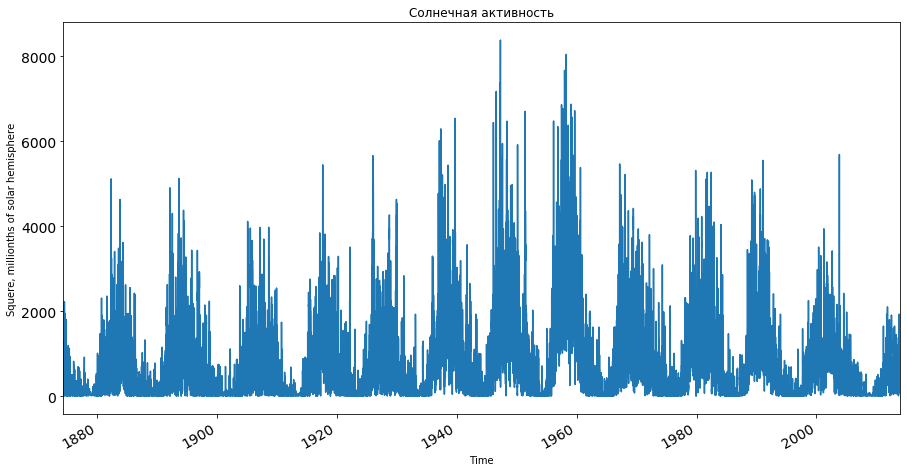

In [13]:
squere[['time','sum_squere']].plot('time', figsize=(15,8), title='Солнечная активность', fontsize=14, legend=False)
plt.ylabel("Squere, millionths of solar hemisphere")
plt.xlabel("Time")
plt.show()

Выглядит немного не очень. Давайте еще попробуем приблизить последние лет 50

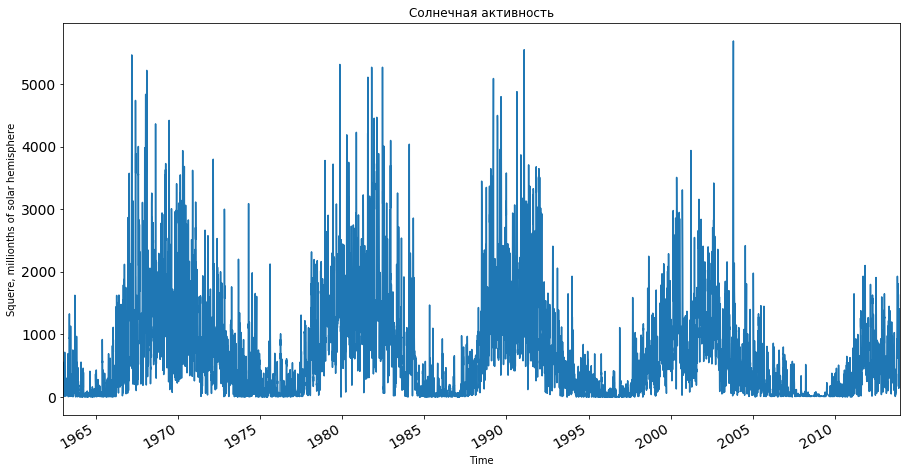

In [14]:
squere[['time','sum_squere']][squere.time >= pd.Timestamp(1963, 1, 1)].plot(
    'time', figsize=(15,8), title='Солнечная активность', fontsize=14, legend=False
)
plt.ylabel("Squere, millionths of solar hemisphere")
plt.xlabel("Time")
plt.show()

Вообще наблюдается определенная сезонность с периодом около 10 лет, не так ли?

### Смотрим на пятна

Разделим пятна на северные и южные

In [15]:
north_df = df[(df.angle < 90.0) | (df.angle >= 270.0)]
temp = {}
for row in map(lambda i: north_df.iloc[i], range(north_df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

south = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

south_df = df[(df.angle >= 90.0) & (df.angle < 270.0)]
temp = {}
for row in map(lambda i: south_df.iloc[i], range(south_df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

north = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

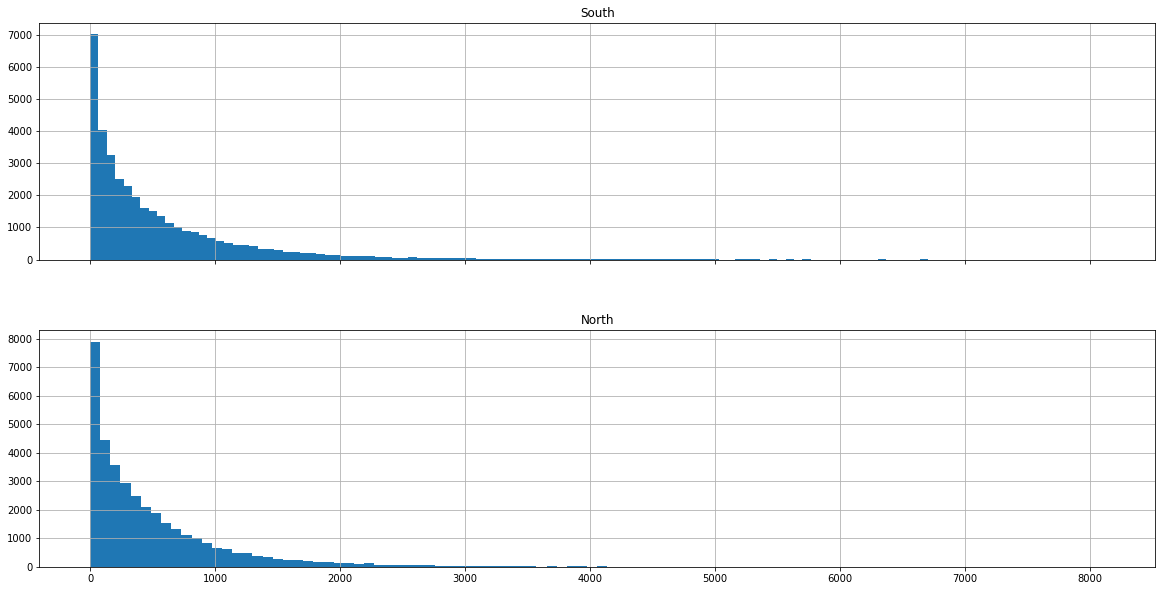

In [16]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, sharex=True, figsize=(20, 10)
)
south.hist(column='sum_squere', bins=100, ax=ax1)
north.hist(column="sum_squere", bins=100, ax=ax2)
ax1.set_title("South")
ax2.set_title("North")
plt.show()

Весьма занятная форма распределений вообще говоря. Хотя внешне похожи. Радует

Попробуем построить средние, чтобы пользоваться в будущем в том числе параметрическими критериями

In [17]:
import numpy as np

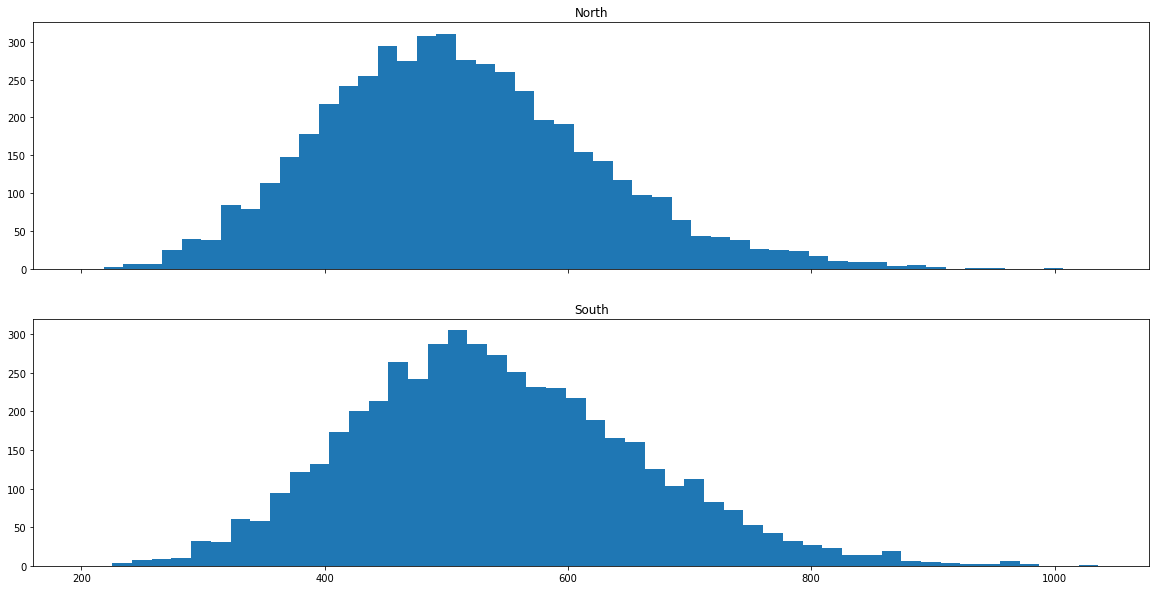

In [23]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, sharex=True, figsize=(20, 10)
)
n = 30
north_means = [np.mean(np.random.choice(north.sum_squere, n)) for _ in range(5000)]
ax1.hist(north_means, bins=50)
ax1.set_title("North")
south_means = [np.mean(np.random.choice(south.sum_squere, n)) for _ in range(5000)]
ax2.hist(south_means, bins=50)
ax2.set_title("South")
plt.show()

## Проверка статистических гипотез

### Запятненность севера и юга из одного распределения?

H0: площадь пятен на севере и на юге принадлежат одному распределению

H1: площадь пятен на севере и на юге принадлежат разным распределениям

Ну, это два множества объектов. Кажется, уместно применить критерий Стьюдента для несвязанных выборок
Хотя на всякий случай давайте проверим распределения на нормальность. ЦПТ, конечно, никто не отменял, но может быть я где-то был не прав

In [25]:
from scipy import stats

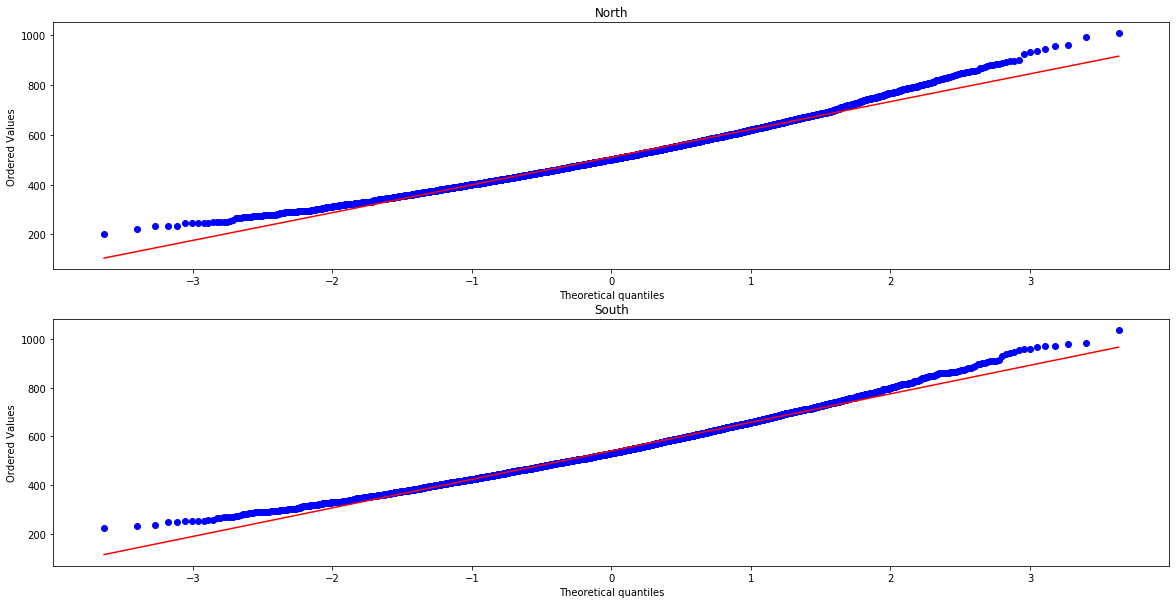

In [31]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, figsize=(20, 10)
)
stats.probplot(north_means, dist="norm", plot=ax1)
ax1.set_title("North")
stats.probplot(south_means, dist="norm", plot=ax2)
ax2.set_title("South")
plt.show()

In [86]:
t_stat = stats.ttest_ind(north_means, south_means)
t_stat

Ttest_indResult(statistic=-13.340963575086779, pvalue=2.951137969197117e-40)

Очень интересно! Действительно разные распределения! H0 отвергнута

## Анализ временного ряда

## Вывод